## Import necessary Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import seaborn as sns

#### Load and save model function

In [2]:
import pickle
# Save model
def save_model(file_name, model):
    with open('/kaggle/working/'+file_name,'wb') as f:
        pickle.dump(model,f)
    f.close()

# Load model
def load_model(file_name):
    with open('/kaggle/working/'+file_name,'rb') as f:
        model = pickle.load(f)
    f.close()
    return model

### Data loading

In [3]:
data_path = '/kaggle/input/cic-iot-2023/CIC IoT 2023/'
dfs = []
for i in range(0,5):
    train_file = f'part-{i:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'
    dfs.append(pd.read_csv(data_path+train_file))
    print(len(dfs[i]))
    print(train_file)
    
df = pd.concat(dfs, ignore_index=True)
print(len(df))

238687
part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
218805
part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
275258
part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
231023
part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
227491
part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
1191264


In [4]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0.0,0.0,0.0,...,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0.0,1.0,0.0,...,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191264 entries, 0 to 1191263
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1191264 non-null  float64
 1   Header_Length    1191264 non-null  float64
 2   Protocol Type    1191264 non-null  float64
 3   Duration         1191264 non-null  float64
 4   Rate             1191264 non-null  float64
 5   Srate            1191264 non-null  float64
 6   Drate            1191264 non-null  float64
 7   fin_flag_number  1191264 non-null  float64
 8   syn_flag_number  1191264 non-null  float64
 9   rst_flag_number  1191264 non-null  float64
 10  psh_flag_number  1191264 non-null  float64
 11  ack_flag_number  1191264 non-null  float64
 12  ece_flag_number  1191264 non-null  float64
 13  cwr_flag_number  1191264 non-null  float64
 14  ack_count        1191264 non-null  float64
 15  syn_count        1191264 non-null  float64
 16  fin_count        1

In [6]:
df.describe(include= 'all')

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
count,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,...,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1.191264e+06,1191264
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DDoS-ICMP_Flood
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183192
mean,5.826951e+00,7.759036e+04,9.062356e+00,6.636330e+01,9.098259e+03,9.098259e+03,1.659157e-06,8.652238e-02,2.072580e-01,9.054332e-02,...,3.346122e+01,1.249189e+02,8.317171e+07,9.497923e+00,1.312772e+01,4.728593e+01,3.140485e+04,9.638363e-02,1.414980e+02,NaN
std,2.994739e+02,4.664047e+05,8.931872e+00,1.411866e+01,9.978758e+04,9.978758e+04,7.979995e-04,2.811340e-01,4.053422e-01,2.869587e-01,...,1.621024e+02,2.429693e+02,1.704689e+07,8.191521e-01,8.642407e+00,2.292664e+02,3.620606e+05,2.328537e-01,2.106700e+01,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.200000e+01,0.000000e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,NaN
25%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,2.091304e+00,2.091304e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.000000e+01,8.307156e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,NaN
50%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,1.584020e+01,1.584020e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.400000e+01,8.312451e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,NaN
75%,1.043421e-01,2.846775e+02,1.430000e+01,6.400000e+01,1.177502e+02,1.177502e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.753685e-01,5.406000e+01,8.334390e+07,9.500000e+00,1.039673e+01,5.059213e-01,1.369978e+00,8.000000e-02,1.415500e+02,NaN


In [7]:
#Size
df.shape

(1191264, 47)

### Data cleaning 

#### Drop all single value columns

In [8]:
single_value_cols = []
def is_unique(s):                           #   This runs in O(n) compared to O(n log n) nunique() method
    a = s.to_numpy() 
    return (a[0] == a).all()
for i in df.columns:
    if(is_unique(df[i])):
        single_value_cols.append(i)
single_value_cols = ['ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'IRC']

df.drop(single_value_cols,axis=1, inplace=True)     #    Drop all single value columns

#### Correlation matrix heatmap 

In [9]:
### Use this code to demonstrate the detailed correlation matrix.
corr = df.iloc[:,:-1].corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,SSH,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
flow_duration,1.000000,0.010139,0.002019,0.039249,0.001553,0.001553,0.000035,0.005908,0.007783,0.005877,0.004913,0.017181,0.001839,0.003991,0.005013,0.022514,0.019092,0.003125,0.015521,0.005772,0.000566,0.001770,0.004306,0.000025,0.001597,0.008583,0.002604,0.002604,0.008183,0.000511,0.015579,0.008233,0.016283,0.008587,0.002647,0.002539,0.011734,0.016251,0.006052,0.062935,0.002542
Header_Length,0.010139,1.000000,0.046591,0.323537,0.011434,0.011434,0.000345,0.050836,0.084896,0.052098,0.031087,0.187059,0.048200,0.003346,0.049531,0.521398,0.758640,0.014809,0.290046,0.000712,0.001161,0.026032,0.108096,0.000161,0.000753,0.073423,0.000903,0.000903,0.409650,0.341420,0.387073,0.425110,0.328009,0.427811,0.006810,0.008799,0.414760,0.327691,0.191505,0.266468,0.008772
Protocol Type,0.002019,0.046591,1.000000,0.012115,0.018955,0.018955,0.000712,0.105362,0.174806,0.107963,0.106061,0.119863,0.105364,0.161863,0.107203,0.021195,0.032328,0.076751,0.074764,0.006460,0.002210,0.390805,0.449735,0.001128,0.006078,0.396787,0.007062,0.007062,0.326790,0.580439,0.134165,0.335866,0.027661,0.334345,0.003866,0.000789,0.448172,0.027662,0.019902,0.029716,0.000720
Duration,0.039249,0.323537,0.012115,1.000000,0.008807,0.008807,0.000335,0.049276,0.077436,0.039527,0.016424,0.305841,0.030637,0.100811,0.029240,0.261944,0.440960,0.020961,0.404056,0.023407,0.003959,0.068097,0.032363,0.000224,0.022627,0.061857,0.020364,0.020364,0.249593,0.085097,0.334734,0.248055,0.335141,0.211647,0.004284,0.005524,0.234377,0.334868,0.185685,0.443999,0.005482
Rate,0.001553,0.011434,0.018955,0.008807,1.000000,1.000000,0.000187,0.003481,0.031124,0.002380,0.009615,0.016202,0.002557,0.034704,0.000271,0.006582,0.009499,0.007614,0.014002,0.000123,0.000707,0.041363,0.038733,0.000181,0.000235,0.011762,0.000218,0.000218,0.007830,0.005619,0.009024,0.008093,0.007823,0.008164,0.000724,0.000168,0.008765,0.007813,0.004804,0.007503,0.000150
Srate,0.001553,0.011434,0.018955,0.008807,1.000000,1.000000,0.000187,0.003481,0.031124,0.002380,0.009615,0.016202,0.002557,0.034704,0.000271,0.006582,0.009499,0.007614,0.014002,0.000123,0.000707,0.041363,0.038733,0.000181,0.000235,0.011762,0.000218,0.000218,0.007830,0.005619,0.009024,0.008093,0.007823,0.008164,0.000724,0.000168,0.008765,0.007813,0.004804,0.007503,0.000150
Drate,0.000035,0.000345,0.000712,0.000335,0.000187,0.000187,1.000000,0.000640,0.004066,0.000656,0.000645,0.000781,0.000646,0.005253,0.000655,0.000179,0.000246,0.000392,0.000241,0.000024,0.000016,0.001790,0.001079,0.000003,0.000017,0.000919,0.000022,0.000022,0.000589,0.000559,0.000497,0.000607,0.000423,0.000606,0.000023,0.000005,0.000654,0.000422,0.000180,0.000677,0.000005
fin_flag_number,0.005908,0.050836,0.105362,0.049276,0.003481,0.003481,0.000640,1.000000,0.157364,0.974984,0.095454,0.115218,0.985670,0.152306,0.890754,0.026144,0.035968,0.036673,0.007111,0.003545,0.002028,0.264983,0.159685,0.000399,0.002538,0.135971,0.003301,0.003301,0.086229,0.082586,0.071492,0.088888,0.060434,0.088735,0.002987,0.000468,0.095766,0.060385,0.025670,0.096875,0.000472
syn_flag_number,0.007783,0.084896,0.174806,0.077436,0.031124,0.031124,0.004066,0.157364,1.000000,0.161334,0.158622,0.180358,0.160212,0.827910,0.132431,0.043832,0.060304,0.070371,0.017604,0.005889,0.004003,0.440243,0.265300,0.000663,0.004216,0.225903,0.005484,0.005484,0.142302,0.135850,0.118215,0.146698,0.100352,0.146298,0.000027,0.000870,0.156200,0.100273,0.043431,0.114623,0.000857
rst_flag_number,0.005877,0.052098,0.107963,0.039527,0.002380,0.002380,0.000656,0.974984,0.161334,1.000000,0.097884,0.103973,0.961255,0.139611,0.908776,0.026588,0.036771,0.043733,0.004475,0.003634,0.002470,0.271669,0.163714,0.000409,0.002602,0.1

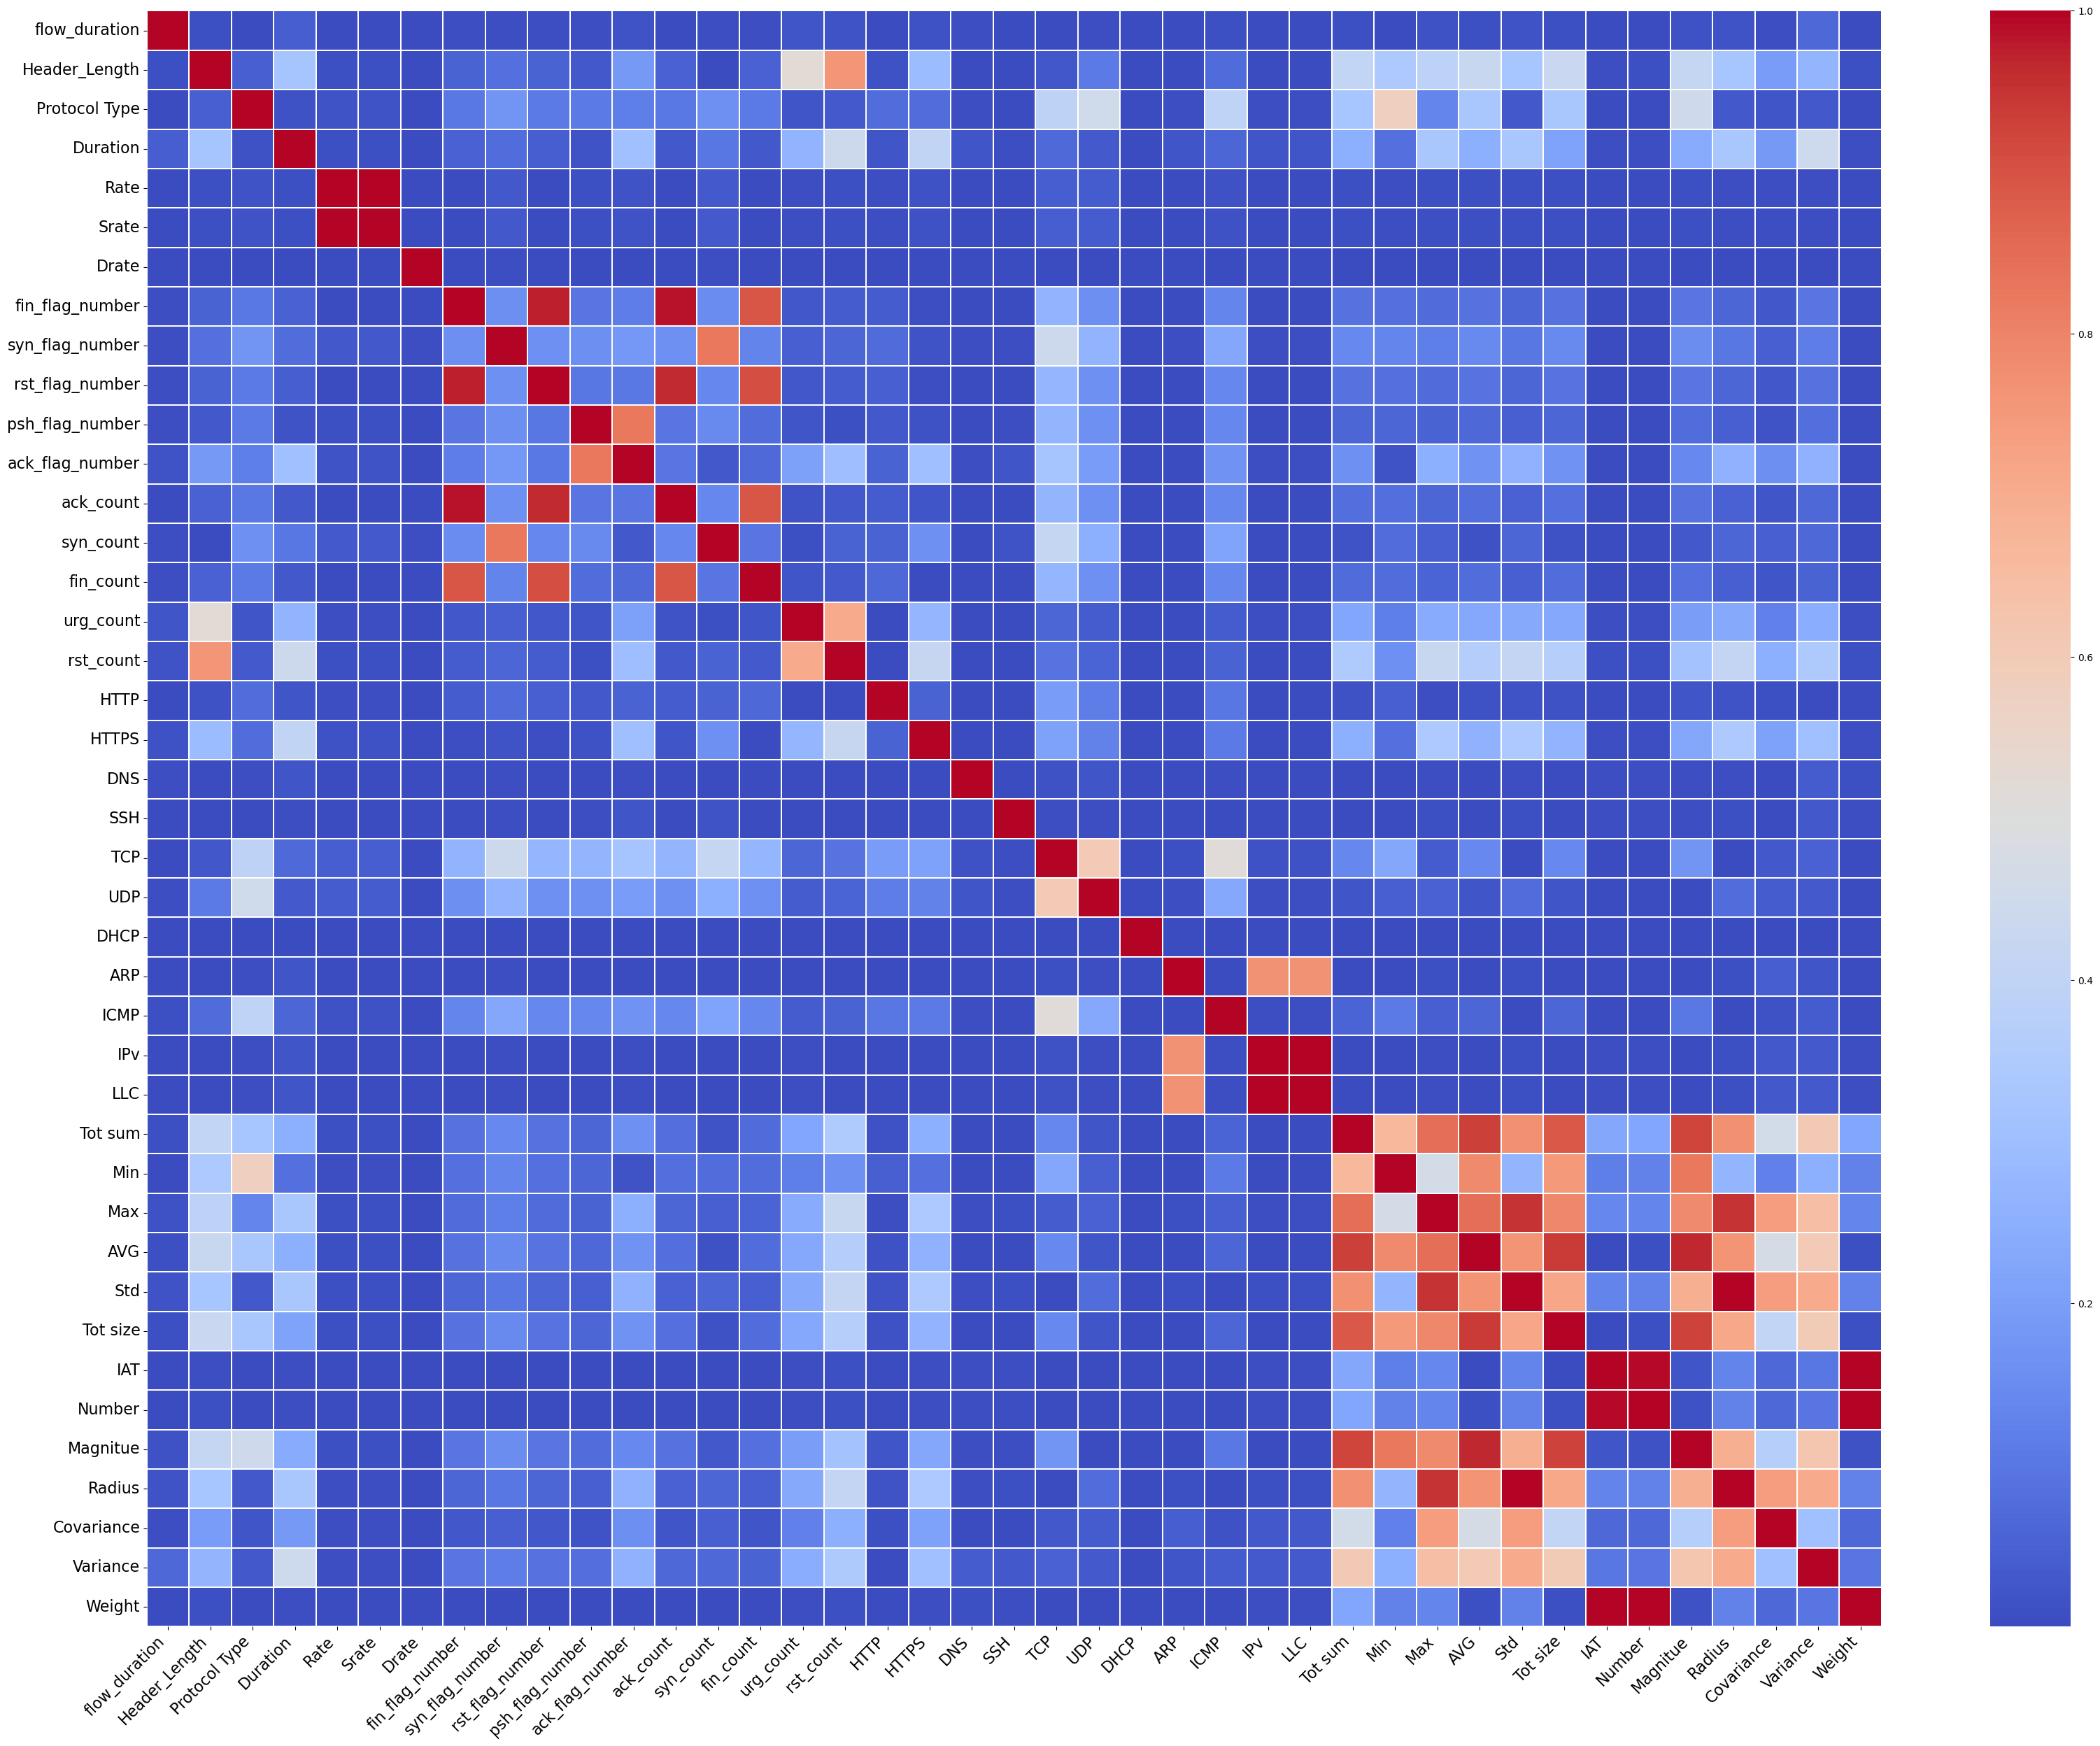

In [10]:
fig, ax = plt.subplots(figsize=(40, 30))  # Set the figure size
new_corr = df.iloc[:,:-1].corr().abs()
sns.heatmap(new_corr, cmap='coolwarm', ax=ax, linewidths=0.1)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.show()


#### Drop all high correlated columns

In [11]:
def get_high_corr_cols(df:pd.DataFrame, threshold):
    cols = []
    df_col = df.columns
    c = {i:[] for i in df_col}
    corr = df.corr().abs().to_numpy()
    for i,corr_i in enumerate(corr):
        for j, corr_i_j in enumerate(corr_i):
            if(corr_i_j > threshold and i!=j):
                c[df_col[i]].append(df_col[j])
    for i in c:
        if(i not in cols and c[i]!=[]):
            cols.extend(c[i])
    return cols

high_corr_cols = ['Srate', 'fin_flag_number', 'rst_flag_number', 'LLC', 'Std', 'Number', 'Magnitue', 'Radius', 'Weight']
df.drop(high_corr_cols,axis=1, inplace=True)

#### Correlation matrix heatmap after drop high correlated columns

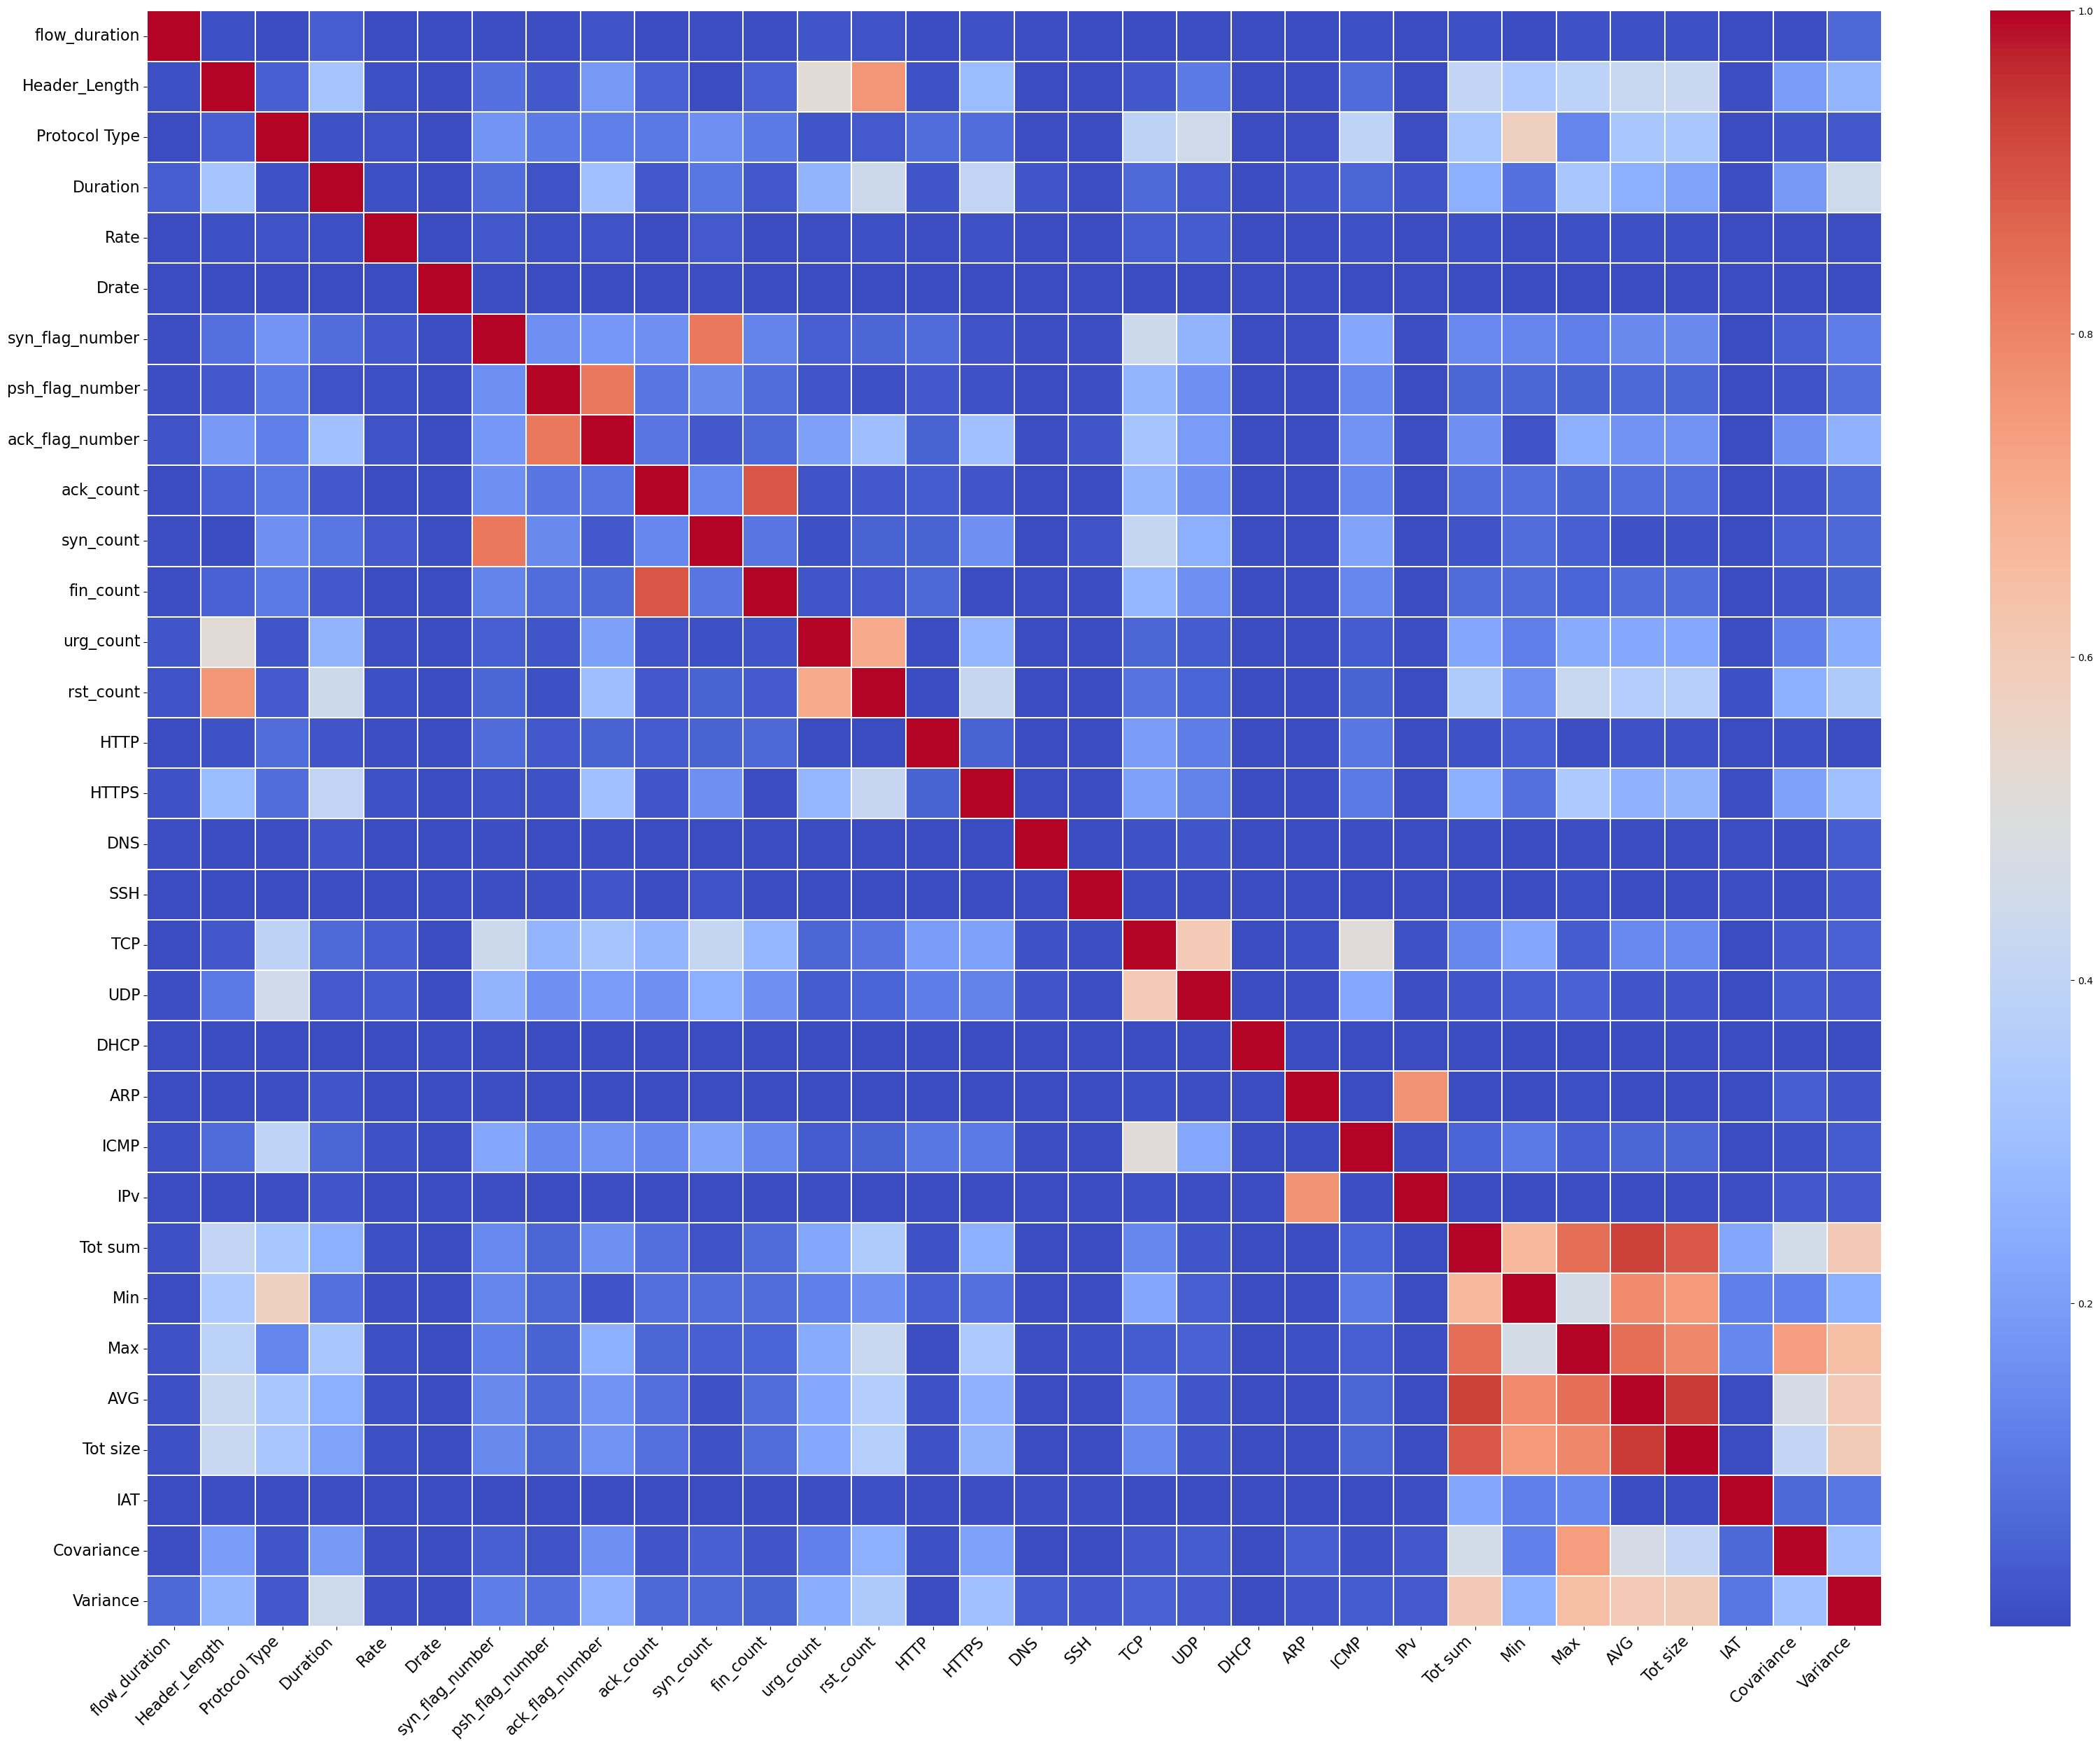

In [12]:
fig, ax = plt.subplots(figsize=(40, 30))  # Set the figure size
new_corr = df.iloc[:,:-1].corr().abs()
sns.heatmap(new_corr, cmap='coolwarm', ax=ax, linewidths=0.1)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.show()


In [13]:
# Use this for standardize custom columns of dataframe
# NOTE: Remember to use the scaler with the test data to scale the data
def custom_col_standardize(df: pd.DataFrame, cols:list = 'all'):
    scalar = StandardScaler()
    scaled_data = df
    if cols == 'all':
        scaled_data.iloc[:,:-1] = pd.DataFrame(scalar.fit_transform(df.iloc[:,:-1])) 
    else:
        scaled_data.iloc[:,cols] = pd.DataFrame(scalar.fit_transform(df.iloc[:,cols])) 
    return scalar, scaled_data

In [14]:
sub_df = df    # use .sample(n) to get random n row from data frame to create sub_data
sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(1)] # remove nan, inf, -inf value
X = sub_df.iloc[:,:-1].to_numpy()
Y = sub_df.iloc[:,-1].to_numpy()

/tmp/ipykernel_32/2957049766.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(1)] # remove nan, inf, -inf value


In [15]:
def convert_label_to_class_label(Y :np.ndarray):
    Y_class = []
    c = {'DDoS-ICMP_Flood': 'DDos', 'DDoS-RSTFINFlood': 'DDos', 'DDoS-SYN_Flood': 'DDos', 'DDoS-SynonymousIP_Flood': 'DDos', 'DDoS-UDP_Flood': 'DDos', 'DDoS-PSHACK_Flood': 'DDos', 'DDoS-UDP_Fragmentation': 'DDos', 'DDoS-TCP_Flood': 'DDos', 'DDoS-ICMP_Fragmentation': 'DDos', 'DDoS-HTTP_Flood': 'DDos', 'DDoS-ACK_Fragmentation': 'DDos', 'DDoS-SlowLoris': 'DDos', 'DoS-UDP_Flood': 'Dos', 'DoS-TCP_Flood': 'Dos', 'DoS-SYN_Flood': 'Dos', 'DoS-HTTP_Flood': 'Dos', 'Recon-HostDiscovery': 'Recon', 'Recon-PortScan': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon', 'Uploading_Attack': 'Recon', 'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based', 'XSS': 'Web-based', 'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing', 'BrowserHijacking': 'Spoofing', 'DictionaryBruteForce': 'Bruteforce', 'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'BenignTraffic': 'Benign'}
    for i in Y:
        Y_class.append(c[i])
    return np.array(Y_class)


Y_class = convert_label_to_class_label(Y)

#### Split train set and test set for both aspects

In [16]:
# This data for training detailed network attack 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))

print(X_train.shape,X_test.shape)

(953011, 32) (238253, 32)


In [17]:
# This data for training network attack by category
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X,Y_class,test_size=0.2, random_state=random.randint(1,999))

print(X_train_class.shape, X_test_class.shape)

(953011, 32) (238253, 32)


### Model training

In [20]:
# Create model using SVM to classify specific attacks
# Use n_components='mle' to auto guess the dimension else speficy the dimension with int.

SVM_class_clf = make_pipeline(StandardScaler(),PCA(n_components='mle'), SGDClassifier())
SVM_class_clf.fit(X_train_class, Y_train_class)               

save_model('SVM_class.pkl', SVM_class_clf)

In [21]:
SVM_clf = make_pipeline(StandardScaler(),PCA(n_components=20), SGDClassifier())
SVM_clf.fit(X_train, Y_train) 
save_model('SVM.pkl', SVM_clf)

In [18]:
RF_clf = RandomForestClassifier(max_depth=10, max_leaf_nodes=15)
RF_clf.fit(X_train,Y_train)
save_model('RF.pkl', RF_clf)

In [22]:
RF_class_clf = RandomForestClassifier(max_depth=5, max_leaf_nodes=10)
RF_class_clf.fit(X_train_class,Y_train_class)
save_model('RF_class.pkl', RF_class_clf)

In [23]:

SVM_Y_predict_class = SVM_class_clf.predict(X_test_class)
print(metrics.classification_report(Y_test_class, SVM_Y_predict_class))
print("SVM class model accuracy:", metrics.accuracy_score(Y_test_class, SVM_Y_predict_class))


              precision    recall  f1-score   support

      Benign       0.72      0.79      0.75      5571
  Bruteforce       0.91      0.17      0.29        59
        DDos       0.82      0.99      0.90    173638
         Dos       0.71      0.10      0.18     41198
       Mirai       0.99      0.99      0.99     13306
       Recon       0.55      0.36      0.43      1846
    Spoofing       0.68      0.35      0.46      2545
   Web-based       0.00      0.00      0.00        90

    accuracy                           0.82    238253
   macro avg       0.67      0.47      0.50    238253
weighted avg       0.80      0.82      0.77    238253

SVM class model accuracy: 0.8210935434181311


In [24]:
SVM_Y_predict = SVM_clf.predict(X_test)
print(metrics.classification_report(Y_test, SVM_Y_predict))
print("SVM model accuracy:", metrics.accuracy_score(Y_test, SVM_Y_predict))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        21
          BenignTraffic       0.64      0.79      0.71      5562
       BrowserHijacking       0.00      0.00      0.00        40
       CommandInjection       0.00      0.00      0.00        23
 DDoS-ACK_Fragmentation       0.96      0.88      0.92      1481
        DDoS-HTTP_Flood       0.00      0.00      0.00       150
        DDoS-ICMP_Flood       1.00      1.00      1.00     36810
DDoS-ICMP_Fragmentation       1.00      0.93      0.96      2371
      DDoS-PSHACK_Flood       0.99      0.98      0.99     20928
       DDoS-RSTFINFlood       1.00      0.99      1.00     20533
         DDoS-SYN_Flood       0.62      0.96      0.75     20800
         DDoS-SlowLoris       0.00      0.00      0.00       118
DDoS-SynonymousIP_Flood       0.72      0.61      0.66     18357
         DDoS-TCP_Flood       0.64      0.97      0.77     23006
         DDoS-UDP_Flood 

In [25]:
RF_Y_predict_class = RF_class_clf.predict(X_test_class)
print(metrics.classification_report(Y_test_class, SVM_Y_predict_class))
print("Random forest class model accuracy:", metrics.accuracy_score(Y_test_class, RF_Y_predict_class))

              precision    recall  f1-score   support

      Benign       0.72      0.79      0.75      5571
  Bruteforce       0.91      0.17      0.29        59
        DDos       0.82      0.99      0.90    173638
         Dos       0.71      0.10      0.18     41198
       Mirai       0.99      0.99      0.99     13306
       Recon       0.55      0.36      0.43      1846
    Spoofing       0.68      0.35      0.46      2545
   Web-based       0.00      0.00      0.00        90

    accuracy                           0.82    238253
   macro avg       0.67      0.47      0.50    238253
weighted avg       0.80      0.82      0.77    238253

Random forest class model accuracy: 0.9769782542087613


In [19]:
RF_Y_predict = RF_clf.predict(X_test)
print(metrics.classification_report(Y_test, RF_Y_predict))
print("Random forest model accuracy:", metrics.accuracy_score(Y_test, RF_Y_predict))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        21
          BenignTraffic       0.56      0.92      0.70      5562
       BrowserHijacking       0.00      0.00      0.00        40
       CommandInjection       0.00      0.00      0.00        23
 DDoS-ACK_Fragmentation       1.00      0.94      0.97      1481
        DDoS-HTTP_Flood       0.00      0.00      0.00       150
        DDoS-ICMP_Flood       0.97      1.00      0.99     36810
DDoS-ICMP_Fragmentation       1.00      0.97      0.98      2371
      DDoS-PSHACK_Flood       0.98      1.00      0.99     20928
       DDoS-RSTFINFlood       0.98      1.00      0.99     20533
         DDoS-SYN_Flood       0.83      0.99      0.90     20800
         DDoS-SlowLoris       0.00      0.00      0.00       118
DDoS-SynonymousIP_Flood       0.99      0.99      0.99     18357
         DDoS-TCP_Flood       0.79      0.99      0.88     23006
         DDoS-UDP_Flood 

In [26]:
# Cross-validation
df2 = pd.concat([pd.read_csv(data_path+f'part-{x:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv') for x in [random.randrange(169) for i in range(10)]])
print(df2.shape)
df2 = df2.sample(100000)

(2994412, 47)


In [27]:
df2.drop(single_value_cols,axis=1, inplace=True)
df2.drop(high_corr_cols,axis=1, inplace=True) 
X_future_test = df2.iloc[:,:-1].to_numpy()

Y_future_test = df2.iloc[:,-1].to_numpy()
Y_future_test_class = convert_label_to_class_label(Y_future_test)

In [28]:
# Use any model here
clf = load_model('SVM_class.pkl')
Y_future_predict_class = clf.predict(X_future_test)

In [33]:
# Check accuracy here
print(metrics.classification_report(Y_future_test_class, Y_future_predict_class))
print("Model accuracy:", metrics.accuracy_score(Y_future_test_class, Y_future_predict_class))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       0.72      0.78      0.75      2286
  Bruteforce       0.75      0.12      0.21        24
        DDos       0.82      0.99      0.90     72842
         Dos       0.70      0.10      0.17     17227
       Mirai       0.99      0.99      0.99      5738
       Recon       0.52      0.33      0.40       781
    Spoofing       0.68      0.36      0.47      1070
   Web-based       0.00      0.00      0.00        32

    accuracy                           0.82    100000
   macro avg       0.65      0.46      0.49    100000
weighted avg       0.80      0.82      0.77    100000

Model accuracy: 0.8209


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
